In [1]:
import os, cv2, itertools # cv2 -- OpenCV
import numpy as np 
import pandas as pd 
import keras
 
import matplotlib.pyplot as plt 
%matplotlib inline

Using TensorFlow backend.
C:\Users\ktiwari\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ktiwari\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ktiwari\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ktiwari\Anaconda3\lib\site-packages\tensorflow\python\framework\d

In [2]:
# libraries imported
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.layers import BatchNormalization
from keras.layers import Activation
 

1.	Change the below path for directory to the location where your “Eye” Folder (downloaded above) is available. 
directory = 'C:/Users/ktiwari/Documents/USF/Kirti/USF CourseWork/2nd Sem/DSP-6930/eye_dataset/eye/' # only have to change this path 
Note : Replace the “\” with “/” and provide “ / “ at the end of the path.
2.	Search for ‘haarcascade_frontalface_default.xml’ in windows search and open the file found.
It will open in explorer and copy the full path from there.
Use this path which you copied above and replace in the face_cascade section in below part of the code, also replace the “\” with “/”
3.	Similar activity needs to be done for eye_cascade as well. Search for ‘haarcascade_eye.xml'
4. Refer ReadME for more details


In [3]:
directory = 'C:/Users/ktiwari/Documents/USF/Kirti/USF CourseWork/2nd Sem/DSP-6930/eye_dataset/eye/' # only have to change this path
TRAIN_DIR = directory+'Data/'
TEST_DIR = directory+'Test/'
# Need to set up paths for face_cascade and eye_cascade manually 
face_cascade = cv2.CascadeClassifier('C:/Users/ktiwari/Anaconda3/Lib/site-packages/cv2/data/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('C:/Users/ktiwari/Anaconda3/Lib/site-packages/cv2/data/haarcascade_eye.xml')

\\

In [4]:
train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
#test_images = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

In [5]:
# load suspicious vs clean dataset, reshape and save to a new folder

from os import listdir
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
# define location of dataset
folder = TRAIN_DIR
photos, labels = list(), list()
# enumerate files in the directory
for file in listdir(folder):
    # determine class
    output = 0.0
    if file.startswith('sus'):
        output = 1.0
    # load image
    photo = load_img(folder + file, target_size=(200, 200))
    # convert to numpy array
    photo = img_to_array(photo)
    # store
    photos.append(photo)
    labels.append(output)
# convert to a numpy arrays
photos = asarray(photos)
labels = asarray(labels)
print(photos.shape, labels.shape)
# save the reshaped photos
save('photos.npy', photos)
save('labels.npy', labels)

(82, 200, 200, 3) (82,)


In [6]:
# load and confirm the shape
from numpy import load
photos = load('photos.npy')
labels = load('labels.npy')
print(photos.shape, labels.shape)

(82, 200, 200, 3) (82,)


In [7]:
# We will move the images based on the labels to their respective folders, so we will delete the existing directories if any
# and recreate them
from os import makedirs
from os import rmdir

import shutil

# delete directories for images
dataset_home = directory+'dataset_eyes_sus_vs_clean/'
if os.path.exists(dataset_home+'train/sus/'):
    shutil.rmtree(dataset_home+'train/sus/')
    shutil.rmtree(dataset_home+'train/clean/')
    shutil.rmtree(dataset_home+'valid/clean/')
    shutil.rmtree(dataset_home+'valid/sus/')
    shutil.rmtree(dataset_home)
    

In [8]:
# organize dataset into a useful structure and extract eyes 
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
import numpy as np
import cv2
# create directories
dataset_home = directory+'dataset_eyes_sus_vs_clean/'
subdirs = ['train/', 'valid/']
for subdir in subdirs:
    # create label subdirectories
    labeldirs = ['sus/', 'clean/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        makedirs(newdir, exist_ok=True)
# seed random number generator
seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.2
# copy training dataset images into subdirectories
src_directory = TRAIN_DIR
for file in listdir(src_directory):
    src = src_directory + '/' + file
    dst_dir = 'train/'
    if random() < val_ratio:
        dst_dir = 'valid/'
    if file.startswith('sus'):
        img = cv2.imread(TRAIN_DIR+file)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        for (x,y,w,h) in faces:
            img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = img[y:y+h, x:x+w]
    #cv2.imshow("cropped", roi_color)
            eyes = eye_cascade.detectMultiScale(roi_gray)
            i=0
            for (ex,ey,ew,eh) in eyes:
                cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        #filename = 'C:/Users/Admin/Desktop/KT/test/savedImage'+str(i)+'.jpg'
        #cv2.imwrite(filename, cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2))
                eyes1 = roi_color[ey:ey+eh, ex:ex+ew]
                #cv2.imshow("cropped", eyes1)
                #cv2.imwrite(filename.replace('.jpg','')+str(i)+'.jpg', eyes1)
                i=i+1
                dst = dataset_home + dst_dir + 'sus/'  + file.replace('.jpg','')+str(i)+'.jpg'
                cv2.imwrite(dst, eyes1)
                #copyfile(src, dst)
    elif file.startswith('clean'):
        img = cv2.imread(TRAIN_DIR+file)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        for (x,y,w,h) in faces:
            img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = img[y:y+h, x:x+w]
    #cv2.imshow("cropped", roi_color)
            eyes = eye_cascade.detectMultiScale(roi_gray)
            i=0
            for (ex,ey,ew,eh) in eyes:
                cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        #filename = 'C:/Users/Admin/Desktop/KT/test/savedImage'+str(i)+'.jpg'
        #cv2.imwrite(filename, cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2))
                eyes1 = roi_color[ey:ey+eh, ex:ex+ew]
                #cv2.imshow("cropped", eyes1)
                #cv2.imwrite(filename.replace('.jpg','')+str(i)+'.jpg', eyes1)
                i=i+1
                dst = dataset_home + dst_dir + 'clean/'  + file.replace('.jpg','')+str(i)+'.jpg'
                cv2.imwrite(dst, eyes1)
                #copyfile(src, dst)

In [9]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                  shear_range=0.15,
                                  zoom_range=0.2,
                                  #rotation_range=45,
                                  #width_shift_range=[-0.2,0.2],
                                  #height_shift_range=0.25,
                                  brightness_range=[0.5,1.5],
                                  horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_it = train_datagen.flow_from_directory(directory+'dataset_eyes_sus_vs_clean/train/',
        class_mode='binary', batch_size=10, target_size=(20, 20))

val_it = val_datagen.flow_from_directory(directory+'dataset_eyes_sus_vs_clean/valid/',
        class_mode='binary', batch_size=3, target_size=(20, 20))

Found 114 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [10]:
    xavier = keras.initializers.glorot_normal(seed=None)
    he = keras.initializers.he_normal(seed=None)
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(20, 20, 3)))
    model.add(MaxPooling2D((2, 2)))
       
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer=he, padding='same' ))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(40, (3, 3), activation='relu', kernel_initializer=he, padding='same' ))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(55, (3, 3), activation='relu', kernel_initializer=xavier, padding='same' ))
    model.add(MaxPooling2D((2, 2)))
    
    #model.add(Conv2D(64, (2, 2))) 
    #model.add(Activation('relu')) 
    #model.add(MaxPooling2D(pool_size=(2, 2))) 
    
                    
    model.add(Flatten())
    model.add(Dropout(0.5)) 
    
    model.add(Dense(128, activation='relu', kernel_initializer=he,kernel_regularizer=regularizers.l2(0.02)))#70
    
    model.add(Dense(200)) #64
    model.add(Activation('relu')) 
    
    #model.add(Dense(350)) #Added in new run
    #model.add(Activation('relu')) 
   

     
    model.add(Dense(1)) 
    model.add(Activation('sigmoid')) 
    
    model.summary()
    # compile model
    #opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    #model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])
    
    # compile model 2
    #sgd = keras.optimizers.SGD(lr=0.08)
    #model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    #compile model 3
    #adam = keras.optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)
    #model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    #complie model 4
    #nesterov_adam = keras.optimizers.Nadam(lr=1e-6, beta_1=0.9, beta_2=0.999, schedule_decay=0.004)
    #model.compile(loss='binary_crossentropy', optimizer=nesterov_adam, metrics=['accuracy'])
    

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 20, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 40)          11560     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 40)          0         
________________________________________________

In [11]:
from IPython.display import display
from PIL import Image

history = model.fit_generator( train_it,
                         steps_per_epoch=len(train_it),
                         epochs=20,
                         validation_data= val_it,
                         validation_steps= len(val_it))

# evaluate model
#classifier.evaluate_generator(test_it, steps=len(test_it), verbose=0)


Instructions for updating:
Use tf.cast instead.
Epoch 1/20
12/12 [==============================] - 1s 96ms/step - loss: 5.3230 - accuracy: 0.6579 - val_loss: 5.0446 - val_accuracy: 0.5000
Epoch 2/20
12/12 [==============================] - 0s 25ms/step - loss: 4.8535 - accuracy: 0.6228 - val_loss: 4.6237 - val_accuracy: 0.5000
Epoch 3/20
12/12 [==============================] - 1s 47ms/step - loss: 4.4056 - accuracy: 0.6404 - val_loss: 4.1369 - val_accuracy: 0.6000
Epoch 4/20
12/12 [==============================] - 0s 33ms/step - loss: 4.0380 - accuracy: 0.6754 - val_loss: 3.9488 - val_accuracy: 0.5000
Epoch 5/20
12/12 [==============================] - 0s 38ms/step - loss: 3.6711 - accuracy: 0.7368 - val_loss: 3.6751 - val_accuracy: 0.5000
Epoch 6/20
12/12 [==============================] - 0s 39ms/step - loss: 3.3241 - accuracy: 0.7193 - val_loss: 3.0481 - val_accuracy: 0.5000
Epoch 7/20
12/12 [==============================] - 1s 61ms/step - loss: 3.0457 - accuracy: 0.7281 - val_l

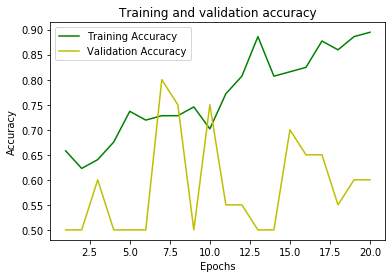

In [12]:
# for plotting the graph... 
plt.clf()
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'y', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

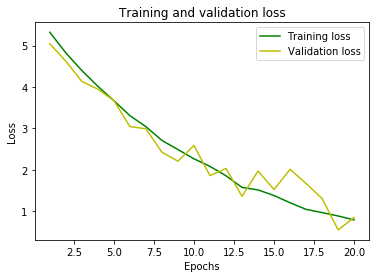

In [13]:
# for plotting the graph... 
plt.clf()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
# Load the data for making predictions
test_datagen = ImageDataGenerator(rescale = 1./255)
prediction_set = test_datagen.flow_from_directory(directory+'Test/', # relative path from working directoy
                                            target_size = (20, 20),batch_size=1,
                                            class_mode = 'binary')

Found 21 images belonging to 1 classes.


In [15]:
predictions=model.predict(prediction_set)

In [16]:
i=np.random.choice(len(predictions))

In [17]:
# Predicting all images in the folder
for img in range(len(predictions)):
    print(prediction_set.filenames[img],predictions[img],"Suspicious" if predictions[img] > 0.65 else "Clean")

predict\clean.1.jpg [0.9961158] Suspicious
predict\clean.2.jpg [0.8536791] Suspicious
predict\clean.3.jpg [0.17145965] Clean
predict\clean.4.jpg [0.29318327] Clean
predict\clean.5.jpg [0.8781864] Suspicious
predict\clean.6.jpg [0.97779936] Suspicious
predict\clean.7.jpg [0.7109515] Suspicious
predict\clean.8.jpg [0.21021189] Clean
predict\clean.9.jpg [0.79737073] Suspicious
predict\suspicious.1.jpg [0.33172354] Clean
predict\suspicious.11.jpg [0.2940436] Clean
predict\suspicious.12.jpg [0.2535259] Clean
predict\suspicious.13.jpg [0.99522793] Suspicious
predict\suspicious.17.jpg [0.08307195] Clean
predict\suspicious.2.jpg [0.7837547] Suspicious
predict\suspicious.3.jpg [0.9974963] Suspicious
predict\suspicious.4.jpg [0.34347188] Clean
predict\suspicious.55.jpg [0.29722363] Clean
predict\suspicious.6.jpg [0.20616783] Clean
predict\suspicious.7.jpg [0.93847084] Suspicious
predict\suspicious.8.jpg [0.18193702] Clean
